In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
# Load the Excel files
images_df = pd.read_excel('./data/Cases_Images.xlsx')
meta_df = pd.read_excel('./data/Cases_Meta_data.xlsx', header=1)

images_df = images_df.iloc[:, :2]
meta_df = meta_df.iloc[:, :3]

meta_df.rename(columns={"Case Number": "Case_Number", "HPV": "Label"}, inplace=True)
images_df.rename(columns={"Case Number": "Case_Number"}, inplace=True)

# Merge the dataframes on 'Case_Number'
# Since images_df has multiple rows for the same Case Number, the merge will duplicate meta_df's data to match.
merged_df = pd.merge(images_df, meta_df, on='Case_Number', how='left')
print(merged_df.head())

   Case_Number       File CaseID     Label
0            1  AAAW1.jpg   AAAW  Positive
1            1  AAAW3.jpg   AAAW  Positive
2            1  AAAW2.jpg   AAAW  Positive
3            1  AAAW4.jpg   AAAW  Positive
4            2  AADE0.jpg   AADE  Negative


In [44]:
# Define the class labels (assuming the label column is 'Label' and contains 'positive', 'negative', 'unknown')
class_labels = merged_df['Label'].unique()

# Create directories for train, val, and test
base_dir = 'processed_data'
os.makedirs(base_dir, exist_ok=True)

for split in ['train', 'val', 'test']:
    for label in class_labels:
        os.makedirs(os.path.join(base_dir, split, label), exist_ok=True)

# Split the data into train, val, and test
train_df, test_df = train_test_split(merged_df, test_size=0.1, stratify=merged_df['Label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['Label'], random_state=42)  # 0.9 * 0.2 = 0.18

# Function to copy images to the corresponding directory
def copy_images(df, split, base_dir):
    for index, row in df.iterrows():
        case_number = row['Case_Number']  # Assuming 'Case_Number' is the correct column name in the merged_df
        label = row['Label']
        
        # Format the case directory name with leading zeros
        case_dir = f'Case {int(case_number):03d}'
        
        # Construct the path to the case folder
        case_path = os.path.join('./data', case_dir)  # Adjust this path as necessary
        
        # Ensure the case folder exists before proceeding
        if os.path.exists(case_path):
            for img_name in os.listdir(case_path):
                src = os.path.join(case_path, img_name)
                dst = os.path.join(base_dir, split, label, img_name)
                shutil.copy(src, dst)
        else:
            print(f"Warning: Directory {case_path} does not exist. Skipping this case.")

# Copy the images
copy_images(train_df, 'train', 'processed_data')
copy_images(val_df, 'val', 'processed_data')
copy_images(test_df, 'test', 'processed_data')

print("Data has been processed and split into train, validation, and test sets.")

Data has been processed and split into train, validation, and test sets.


In [46]:
# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = 'processed_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes (3 classes: positive, negative, unknown)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\Installed\anaconda3\envs\gan\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Installed\anaconda3\envs\gan\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Rashik/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [47]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

                # Deep copy the model
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

model, train_acc, val_acc, train_loss, val_loss = train_model(model, criterion, optimizer, dataloaders, num_epochs=25)


def test_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']

    print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')

    return all_labels, all_preds, test_acc, test_loss

all_labels, all_preds, test_acc, test_loss = test_model(model, dataloaders['test'], criterion)

Epoch 0/24
----------
train Loss: 0.9659 Acc: 0.5787
val Loss: 0.9879 Acc: 0.6095
Epoch 1/24
----------
train Loss: 0.6158 Acc: 0.6777
val Loss: 1.3725 Acc: 0.5149
Epoch 2/24
----------
train Loss: 0.5871 Acc: 0.7173
val Loss: 0.6900 Acc: 0.6865
Epoch 3/24
----------
train Loss: 0.5114 Acc: 0.7591
val Loss: 0.5807 Acc: 0.7548
Epoch 4/24
----------
train Loss: 0.5028 Acc: 0.7701
val Loss: 0.4876 Acc: 0.7793
Epoch 5/24
----------
train Loss: 0.4510 Acc: 0.7976
val Loss: 0.2854 Acc: 0.8809
Epoch 6/24
----------
train Loss: 0.3517 Acc: 0.8548
val Loss: 0.4415 Acc: 0.8109
Epoch 7/24
----------
train Loss: 0.4347 Acc: 0.8086
val Loss: 1.0356 Acc: 0.6462
Epoch 8/24
----------
train Loss: 0.3185 Acc: 0.8724
val Loss: 0.7080 Acc: 0.7741
Epoch 9/24
----------
train Loss: 0.2665 Acc: 0.8966
val Loss: 0.2425 Acc: 0.9054
Epoch 10/24
----------
train Loss: 0.2450 Acc: 0.9032
val Loss: 0.1971 Acc: 0.9299
Epoch 11/24
----------
train Loss: 0.2275 Acc: 0.9219
val Loss: 0.2183 Acc: 0.9159
Epoch 12/24
--

In [ ]:
# Convert PyTorch tensors to NumPy arrays for plotting
train_acc = [acc.cpu().numpy() for acc in train_acc]
val_acc = [acc.cpu().numpy() for acc in val_acc]
train_loss = [loss for loss in train_loss]  # Loss is typically already a Python float
val_loss = [loss for loss in val_loss]  # Loss is typically already a Python float
test_acc = test_acc.cpu().numpy()  # Convert test accuracy to NumPy
test_loss = test_loss  # Test loss is typically already a Python float

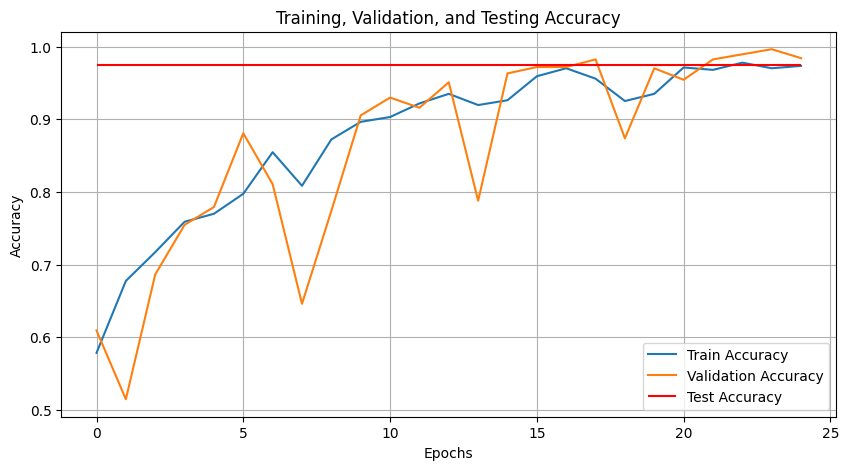

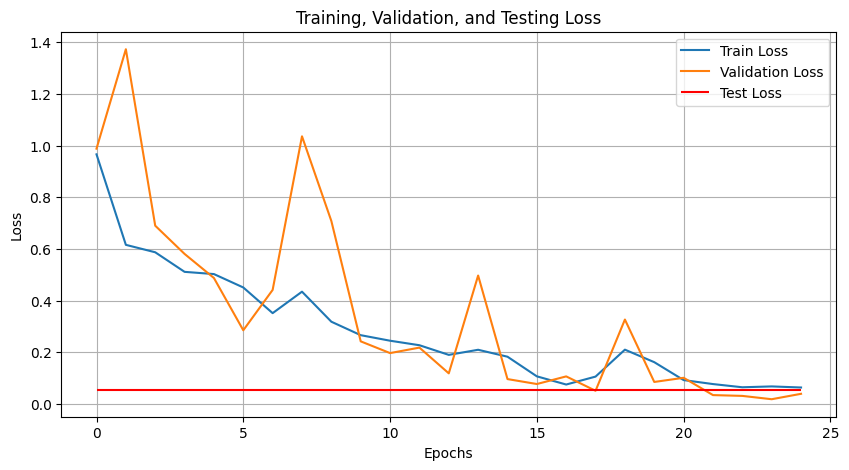

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.99      0.98       173
    Positive       0.98      0.97      0.97       179
     Unknown       1.00      0.60      0.75         5

    accuracy                           0.97       357
   macro avg       0.98      0.85      0.90       357
weighted avg       0.98      0.97      0.97       357

Confusion Matrix
[[172   1   0]
 [  6 173   0]
 [  0   2   3]]


In [51]:
# Plot accuracy and loss
epochs_range = range(len(train_acc))  # Use the actual number of epochs

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.hlines(test_acc, xmin=0, xmax=len(epochs_range)-1, colors='r', label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training, Validation, and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('accuracy.png')
plt.show()

# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.hlines(test_loss, xmin=0, xmax=len(epochs_range)-1, colors='r', label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training, Validation, and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('Loss.png')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix')
print(conf_matrix)